In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.integrate as integrate
import math
import scipy.optimize as opt
import numpy.linalg as lin

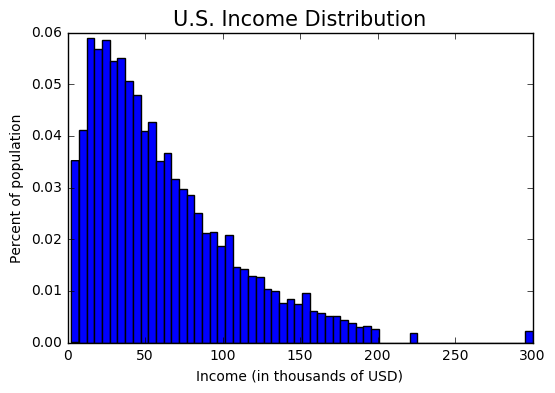

In [138]:
inc = np.loadtxt('/Users/ale/Desktop/MAPSS/Winter/StructuralEstimation/PSet_4/usincmoms.txt')

# (a) Plot Histogram 

adjwgt = inc[:,0]
adjwgt[40] = adjwgt[40]/10
adjwgt[41] = adjwgt[41]/10


n, bin_cuts, patches = plt.hist(inc[:,1]/1000,60,weights = inc[:,0])
plt.title('U.S. Income Distribution', fontsize=15)
plt.xlabel('Income (in thousands of USD)')
plt.ylabel('Percent of population')
plt.show()
plt.savefig('Incdist.png')



(b) Log Normal Estimation
      fun: 0.030471317088770593
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.14786000e-07,  -1.00926212e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 486
      nit: 35
   status: 0
  success: True
        x: array([ 3.93620053,  1.02091247])
mu_GMM = 3.93620053279 sigma_GMM = 1.02091247417


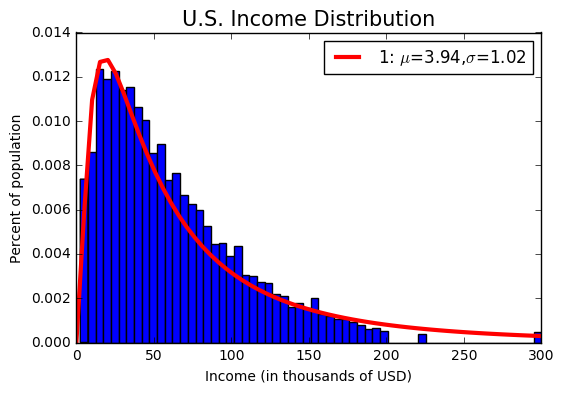

In [139]:
# (b) LogNormal Estimation

datmom = inc[:,0]

# The following variables will 
# be the inputs in the functions
# we define

x_mid = inc[:,1]/1000
x_low = x_mid - 2.5
x_upp = x_mid + 2.5

def modmom_LN(mu,sigma):
    cdf_low = sts.lognorm.cdf(x_low, sigma, scale=math.exp(mu))
    cdf_upp = sts.lognorm.cdf(x_upp, sigma, scale=math.exp(mu))
    # The area between two points will be the 
    # difference of their cdfs
    mmnt = cdf_upp-cdf_low
    return mmnt

def err_LN(xvals, mu, sigma, simple):
    modmom = modmom_LN(mu,sigma)
    if simple:
        err = modmom - datmom
    else:
        err = (modmom - datmom) / datmom
    return err

def crit_LN(params,*args):
    mu, sigma = params
    xvals, W = args
    eps = err_LN(xvals, mu, sigma, simple=False)
    crit = np.dot(np.dot(eps.T, W), eps) 
    return crit

# Optimization

mu_0 = np.mean(x_mid)
sigma_0 = np.std(x_mid)
params_0_LN = np.array([mu_0, sigma_0])

W = np.diag(datmom)
GMM_args = (x_mid, W)

results_b = opt.minimize(crit_LN, params_0_LN, args=(GMM_args),
                       method='L-BFGS-B', bounds=((None, None), (0, None)))

mu_GMM = results_b.x[0]
sigma_GMM = results_b.x[1]

print("(b) Log Normal Estimation")
print(results_b)
print("mu_GMM =",mu_GMM,"sigma_GMM =",sigma_GMM)

# Plot histogram and distribution
n, bin_cuts, patches = plt.hist(inc[:,1]/1000,60,weights = inc[:,0],normed=True)
plotx = np.linspace(0, 300, 60)
plt.plot(plotx, sts.lognorm.pdf(plotx, sigma_GMM, scale=math.exp(mu_GMM)),
         linewidth=3,color='r',label='1: $\mu$=3.94,$\sigma$=1.02')
plt.title('U.S. Income Distribution', fontsize=15)
plt.xlabel('Income (in thousands of USD)')
plt.ylabel('Percent of population')
plt.legend(loc='upper right')
plt.show()
plt.savefig('LNdist.png')

(c) Log Normal Estimation
      fun: 0.0074586877313009836
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24292937e-07,  -9.55832635e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 15
   status: 0
  success: True
        x: array([  1.41578272,  44.97395788])
alpha_GMM = 1.41578272052 beta_GMM = 44.9739578782


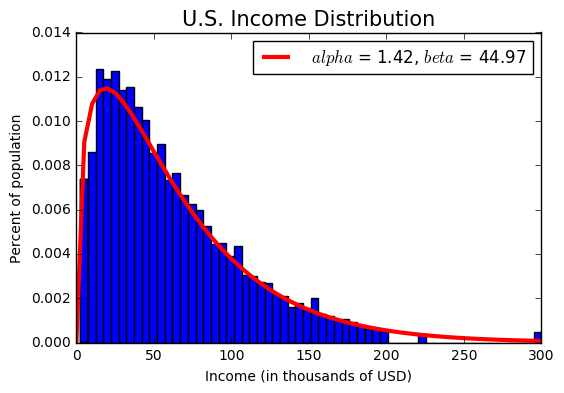

In [140]:
# (c) Gamma Estimation

def modmom_GA(alpha,beta):
    cdf_low = sts.gamma.cdf(x_low,alpha,scale=beta)
    cdf_upp = sts.gamma.cdf(x_upp,alpha,scale=beta)
    mmnt = cdf_upp-cdf_low
    return mmnt

def err_GA(xvals,alpha,beta,simple):
    modmom = modmom_GA(alpha,beta)
    if simple:
        err = modmom - datmom
    else:
        err = (modmom - datmom) / datmom
    return err

def crit_GA(params,*args):
    alpha, beta = params
    xvals, W = args
    eps = err_GA(xvals, alpha,beta, simple=False)
    crit = np.dot(np.dot(eps.T, W), eps) 
    return crit

# Optimization with Gamma Distribution

alpha_0 = 3
beta_0 = 20

# The initial Beta estimate is set to 20 
# instead of 20000 since the income values
# are in thousands of dollars

params_0_GA = np.array([alpha_0, beta_0])

GMM_args = (x_mid, W)

results_c = opt.minimize(crit_GA, params_0_GA, args=(GMM_args),
                       method='L-BFGS-B', bounds=((0, None), (0.0001, None)))


alpha_GMM = results_c.x[0]
beta_GMM = results_c.x[1]

print("(c) Log Normal Estimation")
print(results_c)
print("alpha_GMM =",alpha_GMM,"beta_GMM =",beta_GMM)

# Plot histogram and distribution
n, bin_cuts, patches = plt.hist(inc[:,1]/1000,60,weights = inc[:,0],normed=True)
plt.plot(plotx, sts.gamma.pdf(plotx,alpha_GMM,scale=beta_GMM),
         linewidth=3,color='r',label=' $alpha$ = 1.42, $beta$ = 44.97')
plt.title('U.S. Income Distribution', fontsize=15)
plt.xlabel('Income (in thousands of USD)')
plt.ylabel('Percent of population')
plt.legend(loc='upper right')
plt.show()
plt.savefig('GAdist_1.png')

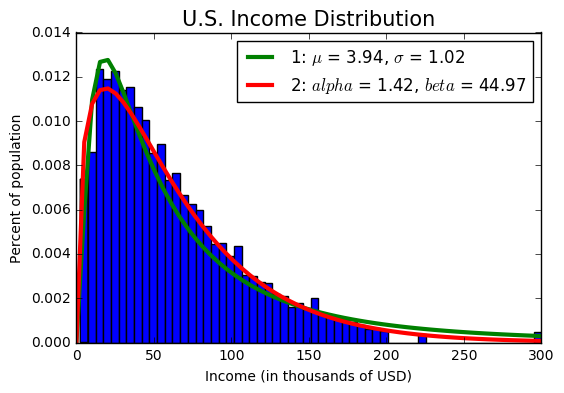

(d) Comparing both distributions
Criterion with Log Normal= 0.0304713170888 Criterion with Gamma= 0.0074586877313


In [141]:
# (d) Comparing Distributions

n, bin_cuts, patches = plt.hist(inc[:,1]/1000,60,weights = inc[:,0],normed=True)

plt.plot(plotx, sts.lognorm.pdf(plotx, sigma_GMM, scale=math.exp(mu_GMM)),
         linewidth=3,color='g',label='1: $\mu$ = 3.94, $\sigma$ = 1.02')
plt.plot(plotx, sts.gamma.pdf(plotx,alpha_GMM,scale=beta_GMM),
         linewidth=3,color='r',label='2: $alpha$ = 1.42, $beta$ = 44.97')

plt.title('U.S. Income Distribution', fontsize=15)
plt.xlabel('Income (in thousands of USD)')
plt.ylabel('Percent of population')
plt.legend(loc='upper right')
plt.show()
plt.savefig('Comparedist.png')

e_LN = err_LN(x_mid, mu_GMM, sigma_GMM, simple=False)
e_GA = err_GA(x_mid, alpha_GMM,beta_GMM, simple=False)
crit_LN = np.dot(np.dot(e_LN.T, W), e_LN)
crit_GA_1 = np.dot(np.dot(e_GA.T, W), e_GA)
print("(d) Comparing both distributions")
print("Criterion with Log Normal=",crit_LN,"Criterion with Gamma=",crit_GA_1)

(e) Two Step Estimation
      fun: 6.3770386049538793e-12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.46988760e-06,   1.41520571e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 17
   status: 0
  success: True
        x: array([ 5.6020839 ,  4.54561494])
alpha_GMM_2stp = 5.60208390184 beta_GMM_2stp = 4.54561494421
Compare with estimation from (c)
Criterion with Gamma= 0.0074586877313 Criterion with Gamma 2 Step= 6.37703860495e-12


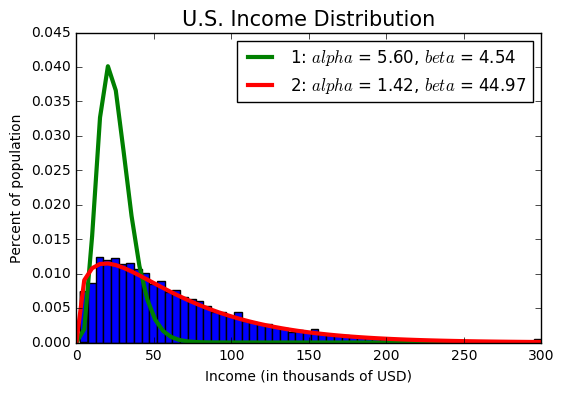

In [142]:
# (e) Use the two step weighting matrix

err_2stp = err_GA(x_mid, alpha_GMM, beta_GMM, False)
e_2stp = err_2stp.reshape((42,1))
VCV2 = np.dot(e_2stp, e_2stp.T) / x_mid.shape[0]
W_2stp = lin.pinv(VCV2)
GMM_args_2stp = (x_mid, W_2stp)
results_e = opt.minimize(crit_GA, params_0_GA, args=(GMM_args_2stp),
                       method='L-BFGS-B', bounds=((0, None), (0.0001, None)))

alpha_GMM_2stp = results_e.x[0]
beta_GMM_2stp = results_e.x[1]

print("(e) Two Step Estimation")
print(results_e)
print("alpha_GMM_2stp =",alpha_GMM_2stp,"beta_GMM_2stp =",beta_GMM_2stp)

e_GA_2stp = err_GA(x_mid, alpha_GMM_2stp,beta_GMM_2stp, simple=False)
crit_GA_2stp = np.dot(np.dot(e_GA_2stp.T, W_2stp), e_GA_2stp)

print("Compare with estimation from (c)")
print("Criterion with Gamma=",crit_GA_1,"Criterion with Gamma 2 Step=",crit_GA_2stp)

n, bin_cuts, patches = plt.hist(inc[:,1]/1000,60,weights = inc[:,0],normed=True)

plt.plot(plotx, sts.gamma.pdf(plotx,alpha_GMM_2stp,scale=beta_GMM_2stp),
         linewidth=3,color='g',label='1: $alpha$ = 5.60, $beta$ = 4.54')
plt.plot(plotx, sts.gamma.pdf(plotx,alpha_GMM,scale=beta_GMM),
         linewidth=3,color='r',label='2: $alpha$ = 1.42, $beta$ = 44.97')

plt.title('U.S. Income Distribution', fontsize=15)
plt.xlabel('Income (in thousands of USD)')
plt.ylabel('Percent of population')
plt.legend(loc='upper right')
plt.show()